In [91]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

<h1>PREPARING DATA</h1>

<h4>0. Input Data</h4>

In [92]:
df = pd.read_excel('input\Class_EK.xlsx')
df.head()

,MQ2,MQ3,MQ4,MQ5,MQ6,MQ7,MQ8,MQ9,MQ135,SPAD,Nitrogen,Flavonoid
0,0.264575,0.374166,0.824621,0.34641,0.141421,0.141421,0.34641,0.4,0.1,38.6,Deficient,Deficient
1,0.264575,0.374166,0.842615,0.34641,0.141421,0.100000,0.34641,0.4,0.1,37.9,Deficient,Deficient
2,0.264575,0.374166,0.854400,0.34641,0.100000,0.100000,0.34641,0.4,0.1,41.4,Deficient,Deficient
3,0.282843,0.374166,0.854400,0.34641,0.141421,0.100000,0.34641,0.4,0.1,41.8,Deficient,Deficient
4,0.264575,0.374166,0.836660,0.34641,0.141421,0.100000,0.34641,0.4,0.1,41.7,Deficient,Deficient


In [93]:
df.drop(['Flavonoid', 'MQ4','MQ6'], axis=1, inplace=True)

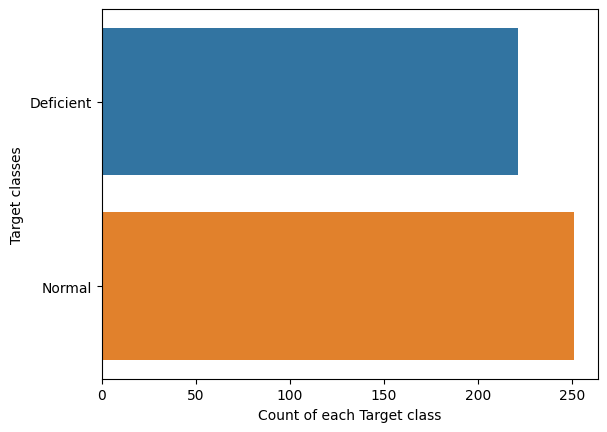

In [94]:
sns.countplot(y=df.Nitrogen, data=df)
plt.xlabel("Count of each Target class")
plt.ylabel("Target classes")
plt.show()

<h4>1. Membagi Data untuk Training dan Testing</h4>

In [95]:
X = df.drop(['Nitrogen'], axis=1)
y = df.Nitrogen
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

<h4>2. Standarisasi Data</h4>

In [96]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)


<h1>METODE 1: KNN</h1>

In [97]:
from sklearn.neighbors import KNeighborsClassifier

<h4>1. Menentukan Nilai k</h4>


The optimal number of neighbors is 1.


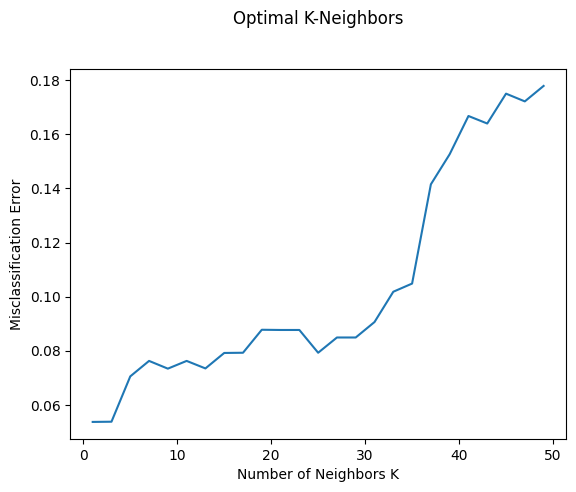

In [98]:
myList = list(range(0, 50))
neighbors = list(filter(lambda x : x % 2 != 0, myList))
neighbors
cv_scores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy' )
    cv_scores.append(scores.mean())

MSE = [1 - x for x in cv_scores]

optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)
plt.plot(neighbors, MSE)
plt.title('Optimal K-Neighbors', y=1.1)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

<h4>2. Tune KNN</h4>

In [99]:
clf = KNeighborsClassifier(metric= 'euclidean', n_neighbors= optimal_k)
clf.fit(X_train, y_train)

y_pred_knn = clf.predict(X_test)
pd.crosstab(y_test, y_pred_knn)

cm = confusion_matrix(y_test, y_pred_knn)
accuracy_KNN = accuracy_score(y_test, y_pred_knn)*100


<h1>METODE 2 : SVM</h1>

In [100]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from transformers import pipeline

<h4>1. Menentukan Parameter Terbaik</h4>

In [101]:
cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=8)

param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    }

gridSearch = GridSearchCV(SVC(), param_grid, cv=cv,
                          scoring=['recall','f1'],refit='f1',verbose=2)
gridSearch.fit(X_train, y_train)
print('Score: ', gridSearch.best_score_)
print('Parameters: ', gridSearch.best_params_)

Fitting 1 folds for each of 8 candidates, totalling 8 fits
[CV] END .........................gamma=scale, kernel=linear; total time=   0.0s
[CV] END ...........................gamma=scale, kernel=poly; total time=   0.0s
[CV] END ............................gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ........................gamma=scale, kernel=sigmoid; total time=   0.0s
[CV] END ..........................gamma=auto, kernel=linear; total time=   0.0s
[CV] END ............................gamma=auto, kernel=poly; total time=   0.0s
[CV] END .............................gamma=auto, kernel=rbf; total time=   0.0s
[CV] END .........................gamma=auto, kernel=sigmoid; total time=   0.0s
Score:  nan
Parameters:  {'gamma': 'scale', 'kernel': 'linear'}


<h4>2. Tune SVM</h4>

In [102]:
svm = make_pipeline(StandardScaler(), SVC(gamma='scale', kernel='linear'))
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
pd.crosstab(y_test, y_pred_svm)

cm = confusion_matrix(y_test, y_pred_svm)
accuracy_SVM = accuracy_score(y_test, y_pred_svm)*100


<h1>METODE 3: Decission Trees (dt)</h1>

In [103]:
from sklearn.tree import DecisionTreeClassifier

<h4>1. Menentukan Parameter Terbaik</h4>

In [104]:
cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=8)

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    }

gridSearch = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=cv,
                          scoring=['recall','f1'],refit='f1',verbose=2)
gridSearch.fit(X_train, y_train)
print('Score: ', gridSearch.best_score_)
print('Parameters: ', gridSearch.best_params_)

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[CV] END .....................................criterion=gini; total time=   0.0s
[CV] END ..................................criterion=entropy; total time=   0.0s
[CV] END .................................criterion=log_loss; total time=   0.0s
Score:  nan
Parameters:  {'criterion': 'gini'}


<h4>2. Tune DT</h4>

In [105]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=10)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
pd.crosstab(y_test, y_pred_dt)

cm = confusion_matrix(y_test, y_pred_dt)
accuracy_DTC = accuracy_score(y_test, y_pred_dt)*100


<h4>>>>> Visualisasi</h4>

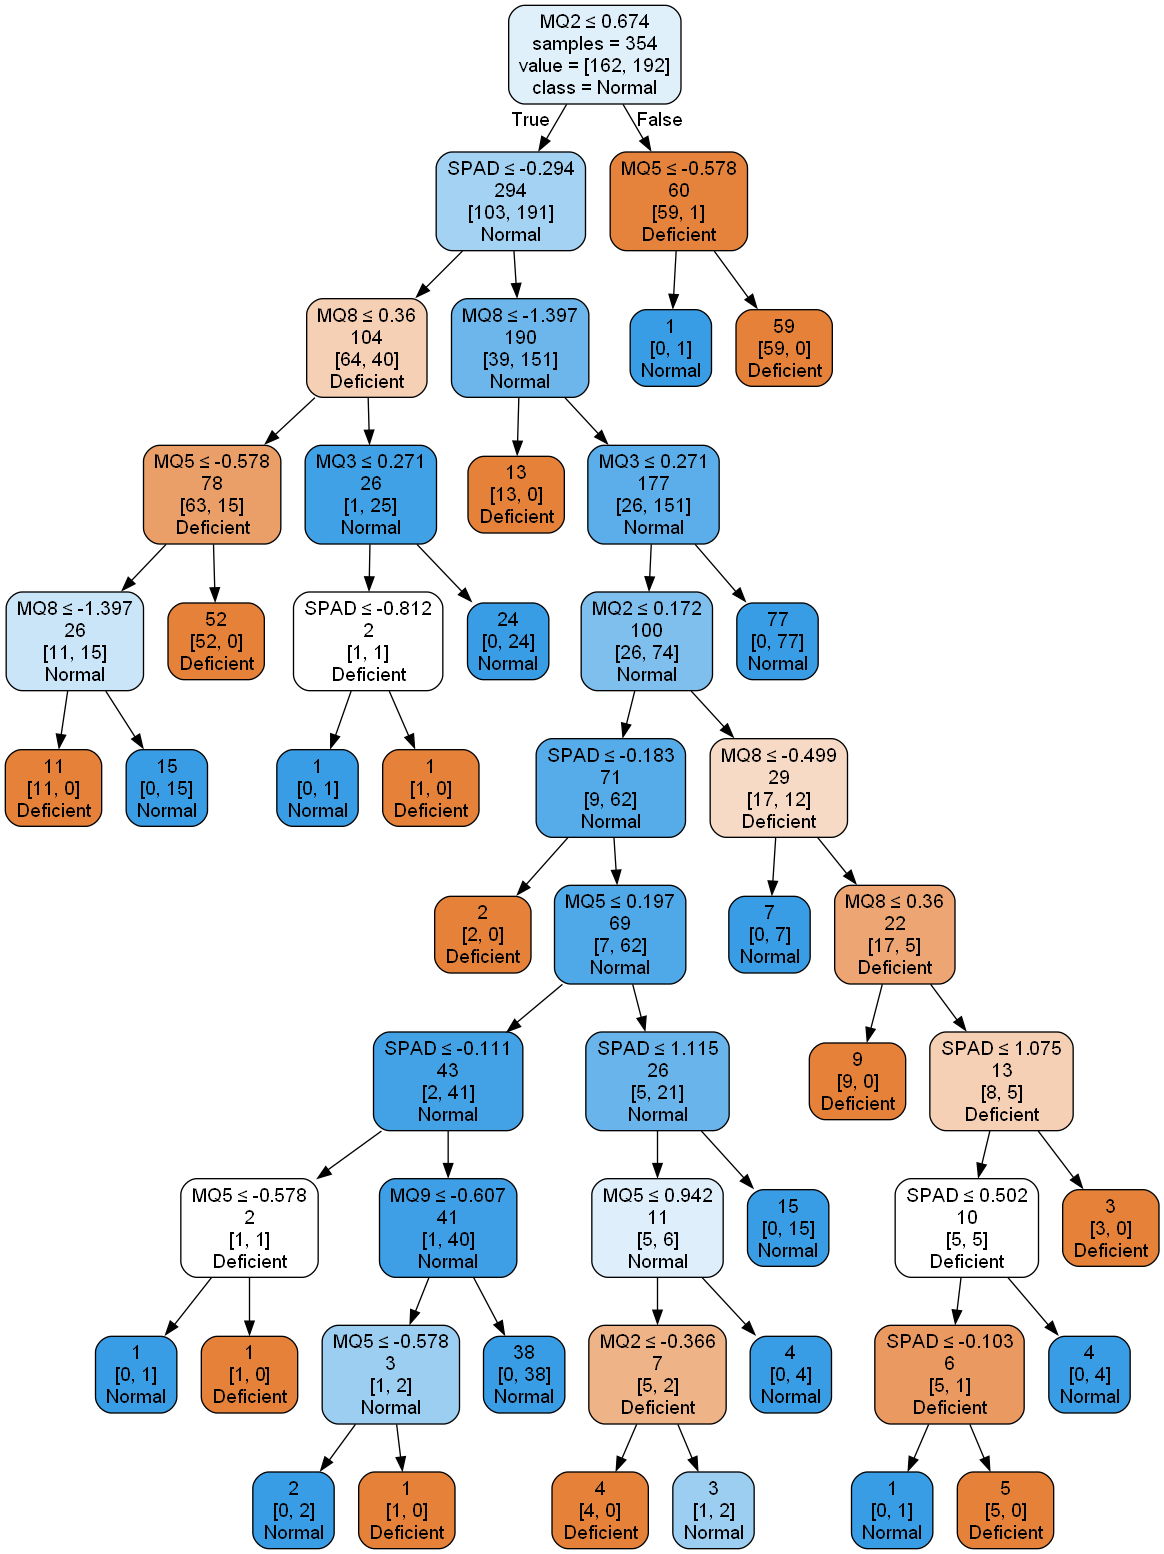

In [106]:
from dmba import plotDecisionTree
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

plotDecisionTree(dt, feature_names=X_train.columns, class_names=dt.classes_)

<h4>1. Preprocessing</h4>

<h1>METODE 4: Multilayer Perceptron (mlp)</h1>

In [107]:
from sklearn.neural_network import MLPClassifier

<h4>1. Menentukan parameter terbaik</h4>

In [108]:
cv = ShuffleSplit(n_splits=1, test_size=0.2, random_state=8)

param_grid = {
    'activation': ['identity','logistic','tanh','relu'],
    'solver': ['lbfgs','sgd','adam']
    }

gridSearch = GridSearchCV(MLPClassifier(), param_grid, cv=cv,
                          scoring=['recall','f1'],refit='f1',verbose=2)
gridSearch.fit(X_train, y_train)
print('Score: ', gridSearch.best_score_)
print('Parameters: ', gridSearch.best_params_)

Fitting 1 folds for each of 12 candidates, totalling 12 fits
[CV] END ..................activation=identity, solver=lbfgs; total time=   0.0s
[CV] END ....................activation=identity, solver=sgd; total time=   0.4s
[CV] END ...................activation=identity, solver=adam; total time=   0.2s
[CV] END ..................activation=logistic, solver=lbfgs; total time=   0.6s
[CV] END ....................activation=logistic, solver=sgd; total time=   0.3s
[CV] END ...................activation=logistic, solver=adam; total time=   1.1s
[CV] END ......................activation=tanh, solver=lbfgs; total time=   0.0s
[CV] END ........................activation=tanh, solver=sgd; total time=   0.5s
[CV] END .......................activation=tanh, solver=adam; total time=   0.6s
[CV] END ......................activation=relu, solver=lbfgs; total time=   0.0s
[CV] END ........................activation=relu, solver=sgd; total time=   0.5s
[CV] END .......................activation=relu,

<h4>2. Tune MLP</h4>

In [109]:
mlp = MLPClassifier(hidden_layer_sizes=10,activation='identity', solver='lbfgs', max_iter=1000,
                            random_state=8)

mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

cm = confusion_matrix(y_test, y_pred_mlp)
accuracy_MLP = accuracy_score(y_test, y_pred_mlp)*100

<h1>COMPARING METHODE</h1>

In [110]:
print("----------------------------MLP-----------------------------------------")
print(classification_report(y_test, y_pred_mlp))
cm = confusion_matrix(y_test, y_pred_mlp)
print('Recall:{:.2f}'.format(recall_score(y_test, y_pred_mlp, average='macro')))
print('Precision:{:.2f}'.format(precision_score(y_test, y_pred_mlp, average='macro')))
print('F1-Score:{:.2f}'.format(f1_score(y_test, y_pred_mlp, average='macro')))

print("----------------------------DT-----------------------------------------")
print(classification_report(y_test, y_pred_dt))
cm = confusion_matrix(y_test, y_pred_dt)
print('Recall:{:.2f}'.format(recall_score(y_test, y_pred_dt, average='macro')))
print('Precision:{:.2f}'.format(precision_score(y_test, y_pred_dt, average='macro')))
print('F1-Score:{:.2f}'.format(f1_score(y_test, y_pred_dt, average='macro')))

print("----------------------------SVM-----------------------------------------")
print(classification_report(y_test, y_pred_svm))
cm = confusion_matrix(y_test, y_pred_svm)
print('Recall:{:.2f}'.format(recall_score(y_test, y_pred_svm, average='macro')))
print('Precision:{:.2f}'.format(precision_score(y_test, y_pred_svm, average='macro')))
print('F1-Score:{:.2f}'.format(f1_score(y_test, y_pred_svm, average='macro')))

print("----------------------------KNN-----------------------------------------")
print(classification_report(y_test, y_pred_knn))
cm = confusion_matrix(y_test, y_pred_knn)
print('Recall:{:.2f}'.format(recall_score(y_test, y_pred_knn, average='macro')))
print('Precision:{:.2f}'.format(precision_score(y_test, y_pred_knn, average='macro')))
print('F1-Score:{:.2f}'.format(f1_score(y_test, y_pred_knn, average='macro')))


print("----------------------------Akurasi-----------------------------------------")
print("Accuracy with K-NN: {0:.2f}%".format(accuracy_KNN))
print("Accuracy with SVM: {0:.2f}%".format(accuracy_SVM))
print("Accuracy with DTC: {0:.2f}%".format(accuracy_DTC))
print("Accuracy with MLP: {0:.2f}%".format(accuracy_MLP))

----------------------------MLP-----------------------------------------
              precision    recall  f1-score   support

   Deficient       0.80      0.73      0.76        59
      Normal       0.75      0.81      0.78        59

    accuracy                           0.77       118
   macro avg       0.77      0.77      0.77       118
weighted avg       0.77      0.77      0.77       118

Recall:0.77
Precision:0.77
F1-Score:0.77
----------------------------DT-----------------------------------------
              precision    recall  f1-score   support

   Deficient       0.89      0.92      0.90        59
      Normal       0.91      0.88      0.90        59

    accuracy                           0.90       118
   macro avg       0.90      0.90      0.90       118
weighted avg       0.90      0.90      0.90       118

Recall:0.90
Precision:0.90
F1-Score:0.90
----------------------------SVM-----------------------------------------
              precision    recall  f1-score   

Text(0.5, 46.681795218841174, 'PREDIKSI')

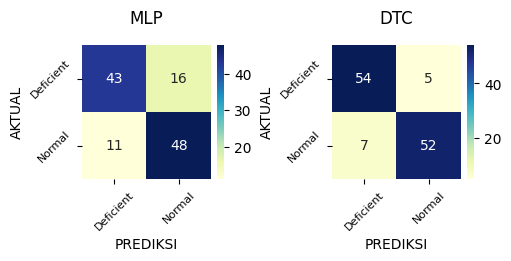

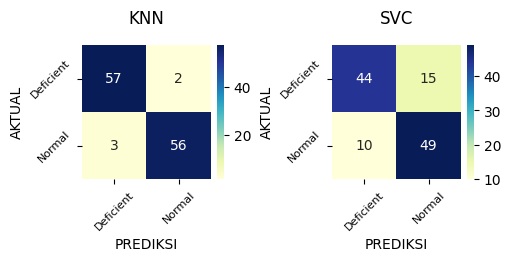

In [111]:
plt.figure(figsize=(5,2.5), layout="constrained")
plt.subplot(1,2,1)
p = sns.heatmap(pd.crosstab(y_test, y_pred_mlp), annot=True, cmap="YlGnBu", fmt='g')
plt.xticks(rotation = 45, fontsize=8)
plt.yticks(rotation = 45, fontsize=8)
plt.title('MLP', y=1.1)
plt.ylabel('AKTUAL')
plt.xlabel('PREDIKSI')

plt.subplot(1,2,2)
p = sns.heatmap(pd.crosstab(y_test, y_pred_dt), annot=True, cmap="YlGnBu", fmt='g')
plt.xticks(rotation = 45, fontsize=8)
plt.yticks(rotation = 45, fontsize=8)
plt.title('DTC', y=1.1)
plt.ylabel('AKTUAL')
plt.xlabel('PREDIKSI')


plt.figure(figsize=(5,2.5), layout="constrained")
plt.subplot(1,2,1)
p = sns.heatmap(pd.crosstab(y_test, y_pred_knn), annot=True, cmap="YlGnBu", fmt='g')
plt.xticks(rotation = 45, fontsize=8)
plt.yticks(rotation = 45, fontsize=8)
plt.title('KNN', y=1.1)
plt.ylabel('AKTUAL')
plt.xlabel('PREDIKSI')

plt.subplot(1,2,2)
p = sns.heatmap(pd.crosstab(y_test, y_pred_svm), annot=True, cmap="YlGnBu", fmt='g')
plt.xticks(rotation = 45, fontsize=8)
plt.yticks(rotation = 45, fontsize=8)
plt.title('SVC', y=1.1)
plt.ylabel('AKTUAL')
plt.xlabel('PREDIKSI')

Text(0.5, -1.777777777777784, 'PREDIKSI')

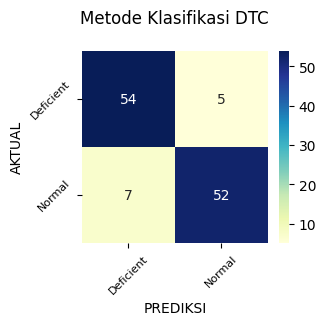

In [112]:

plt.figure(figsize=(3,2.5))
p = sns.heatmap(pd.crosstab(y_test, y_pred_dt), annot=True, cmap="YlGnBu", fmt='g')
plt.xticks(rotation = 45, fontsize=8)
plt.yticks(rotation = 45, fontsize=8)
plt.title('Metode Klasifikasi DTC', y=1.1)
plt.ylabel('AKTUAL')
plt.xlabel('PREDIKSI')